## Differential expression analysis control

As a way of quantifying how similar/different the expression profiles associated with different mutation patterns are, we want to count the number of differentially expressed genes between them. To make sure this makes sense, we first want to take some cancer subtypes we know are quite different, and compare the number of DE genes between them to the number of DE genes between random samples of the same size.

We expect to see that different subtypes have considerably more DE genes between them than random samples taken uniformly from the different subtypes.

In [1]:
from pathlib import Path
import pickle as pkl

import pandas as pd

import sys; sys.path.append('..')
import config as cfg

%load_ext autoreload
%autoreload 2

In [2]:
# if True rerun DE analysis and overwrite existing results 
# if False look for existing results and don't rerun DE analysis
# (the latter makes the notebook run much faster)
RUN_DE_ANALYSIS = False

### Load datasets

In [3]:
# load counts data
all_counts_df = pd.read_csv(cfg.processed_counts_file, sep='\t', index_col=0)
print(all_counts_df.shape)
all_counts_df.iloc[:5, :5]

(10530, 60498)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16
sample_id,,,,,
TCGA-02-0047-01,2132,1,552,387,269
TCGA-02-0055-01,2590,742,2110,493,452
TCGA-02-2483-01,4438,1,2230,735,653
TCGA-02-2485-01,4615,4,1022,629,672
TCGA-04-1331-01,6159,10,2752,1173,1091


In [4]:
# load cancer types
sample_info_df = pd.read_csv(cfg.de_sample_info, sep='\t', index_col=0)
print(sample_info_df.shape)
sample_info_df.head()

(11060, 3)


,sample_type,cancer_type,id_for_stratification
sample_id,,,
TCGA-02-0047-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-0055-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2483-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2485-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2486-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor


In [5]:
# load mutation status
pancancer_pickle = Path('/home/jake/research/mpmp/data/pancancer_data.pkl')
with open(pancancer_pickle, 'rb') as f:
    pancancer_data = pkl.load(f)
    
mutation_df = pancancer_data[1]
print(mutation_df.shape)
mutation_df.iloc[:5, :5]

(9074, 20938)


,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


### DE between IDH1 mutant/wild-type samples in low-grade glioma

In [6]:
cfg.de_input_dir.mkdir(parents=True, exist_ok=True)
cfg.de_output_dir.mkdir(parents=True, exist_ok=True)

base_dir = str(cfg.de_base_dir)
output_dir = str(cfg.de_output_dir)

In [7]:
# get LGG samples from counts data
lgg_samples = (
    sample_info_df[sample_info_df.cancer_type == 'LGG'].index
      .intersection(all_counts_df.index)
      .intersection(mutation_df.index)
)
lgg_counts_df = all_counts_df.loc[lgg_samples, :]
print(lgg_counts_df.shape)
lgg_counts_df.iloc[:5, :5]

(500, 60498)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16
TCGA-CS-4938-01,5768,40,1083,677,369
TCGA-CS-4941-01,5740,91,919,980,554
TCGA-CS-4942-01,4187,0,820,804,433
TCGA-CS-4943-01,3458,2,1344,804,759
TCGA-CS-4944-01,5868,12,712,569,170


In [8]:
# save LGG samples to file, to be loaded by DESeq2
input_file = cfg.de_input_dir / 'lgg_counts.tsv'
input_str = str(input_file)

lgg_counts_df.to_csv(input_file, sep='\t')

In [9]:
# get IDH1 mutation status
idh1_status_df = (mutation_df
    .loc[lgg_samples, ['IDH1']]
    .rename(columns={'IDH1': 'group'})
)
idh1_status_df.head()

,group
TCGA-CS-4938-01,1
TCGA-CS-4941-01,0
TCGA-CS-4942-01,1
TCGA-CS-4943-01,1
TCGA-CS-4944-01,1


In [10]:
# save mutation status to file, to be loaded by DESeq2
input_metadata_file = cfg.de_input_dir / 'lgg_idh1_status.tsv'
input_metadata_str = str(input_metadata_file)

idh1_status_df.to_csv(input_metadata_file, sep='\t')

In [11]:
%load_ext rpy2.ipython

In [12]:
%%R -i RUN_DE_ANALYSIS -i base_dir -i input_metadata_str -i input_str -i output_dir 

if (RUN_DE_ANALYSIS) {
    source(paste0(base_dir, '/de_analysis.R'))

    get_DE_stats_DESeq(input_metadata_str,
                       input_str,
                       'LGG_IDH1',
                       output_dir)
} else {
    print('Skipping DE analysis, will use existing results files')
}

[1] "Skipping DE analysis, will use existing results files"


### DE between random samples in low-grade glioma

We do this to generate an empirical null distribution for our results in IDH1 mutants/wild-type samples.

In [13]:
# number of random samples
n_samples = 5

In [14]:
n_mutated = idh1_status_df.sum().values[0]
n_not_mutated = idh1_status_df.shape[0] - n_mutated
print(n_mutated, n_not_mutated)

387 113


In [15]:
# we can use sklearn train_test_split to partition the data randomly
import numpy as np
from sklearn.model_selection import train_test_split

for sample_ix in range(n_samples):
    _, test_ixs = train_test_split(idh1_status_df.index,
                                   test_size=n_mutated,
                                   shuffle=True,
                                   random_state=sample_ix)
    labels_df = pd.DataFrame(
        np.zeros(idh1_status_df.shape[0]).astype(int),
        index=idh1_status_df.index.copy(),
        columns=['group']
    )
    labels_df.loc[test_ixs, 'group'] = 1
    
    save_file = cfg.de_input_dir / 'lgg_idh1_random_s{}.tsv'.format(sample_ix)
    print(str(save_file))
    labels_df.to_csv(save_file, sep='\t')

/home/jake/research/mutation-fn/4_de_analysis/de_input/lgg_idh1_random_s0.tsv
/home/jake/research/mutation-fn/4_de_analysis/de_input/lgg_idh1_random_s1.tsv
/home/jake/research/mutation-fn/4_de_analysis/de_input/lgg_idh1_random_s2.tsv
/home/jake/research/mutation-fn/4_de_analysis/de_input/lgg_idh1_random_s3.tsv
/home/jake/research/mutation-fn/4_de_analysis/de_input/lgg_idh1_random_s4.tsv


In [16]:
input_metadata_dir = str(cfg.de_input_dir)

In [17]:
%%R -i RUN_DE_ANALYSIS -i base_dir -i input_str -i n_samples -i input_metadata_dir -i output_dir

if (RUN_DE_ANALYSIS) {
    source(paste0(base_dir, '/de_analysis.R'))

    for (i in 0:(n_samples-1)) {
        print(paste('Running: ', i))
        input_metadata_str <- paste(
            input_metadata_dir, '/lgg_idh1_random_s', i, '.tsv',
            sep=''
        )
        get_DE_stats_DESeq(input_metadata_str,
                           input_str,
                           paste('LGG_IDH1_random_s', i, sep=''),
                           output_dir)
    }
} else {
    print('Skipping DE analysis, will use existing results files')
}

[1] "Skipping DE analysis, will use existing results files"


### Compare IDH1 mutation DE results to randomly sampled results

In [18]:
idh1_de_results_df = pd.read_csv(
    cfg.de_output_dir / 'DE_stats_LGG_IDH1.txt',
    sep='\t'
)

print(idh1_de_results_df.shape)
idh1_de_results_df.head()

(60498, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003.14,3132.092116,-0.278504,0.062823,-4.433119,9.287938e-06,4.221955e-05
ENSG00000000005.5,7.983935,-1.643981,0.159215,-10.325560,5.400293e-25,1.414286e-23
ENSG00000000419.12,974.174566,-0.158471,0.028471,-5.566137,2.604485e-08,1.626875e-07
ENSG00000000457.13,729.504306,0.040651,0.025727,1.580107,1.140823e-01,2.454482e-01
ENSG00000000460.16,350.628444,-0.195014,0.062835,-3.103589,1.911885e-03,6.089233e-03


In [19]:
random_de_results = []
for i in range(n_samples):
    
    random_de_results.append(
        pd.read_csv(
            cfg.de_output_dir / 'DE_stats_LGG_IDH1_random_s{}.txt'.format(i),
            sep='\t'
        )
    )
    
print(random_de_results[0].shape)
random_de_results[0].head()

(60498, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003.14,3132.092116,-0.084960,0.063928,-1.329008,0.183845,1.000000
ENSG00000000005.5,7.983935,-0.423665,0.176992,-2.393690,0.016680,0.554189
ENSG00000000419.12,974.174566,0.026013,0.029349,0.886351,0.375428,1.000000
ENSG00000000457.13,729.504306,-0.023396,0.025744,-0.908805,0.363453,1.000000
ENSG00000000460.16,350.628444,0.005244,0.063458,0.082629,0.934147,1.000000


In [20]:
# adjusted p-value threshold
alpha = 0.05

idh1_de_count = (
    (idh1_de_results_df.padj < alpha).sum()
)

random_de_count = [
    (random_de_results[ix].padj < alpha).sum() for ix in range(n_samples)
]

print('DE genes for IDH1 WT vs. mutant:', idh1_de_count)
print('DE genes for random size-matched samples:', random_de_count)

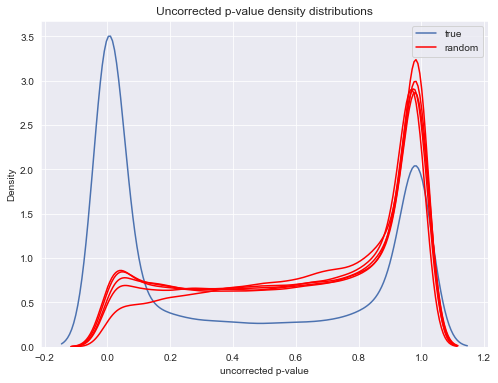

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set({'figure.figsize': (8, 6)})

sns.kdeplot(data=idh1_de_results_df.pvalue, label='true')
for ix in range(n_samples):
    if ix == 0:
        sns.kdeplot(data=random_de_results[ix].pvalue,
                    color='red', label='random')
    else:
        sns.kdeplot(data=random_de_results[ix].pvalue, color='red')
plt.title('Uncorrected p-value density distributions')
plt.xlabel('uncorrected p-value')
plt.legend()

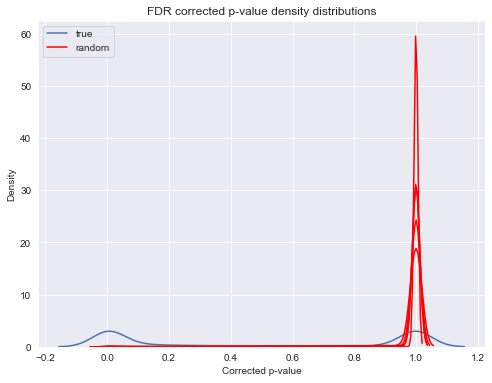

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set({'figure.figsize': (8, 6)})

sns.kdeplot(data=idh1_de_results_df.padj, label='true')
for ix in range(n_samples):
    if ix == 0:
        sns.kdeplot(data=random_de_results[ix].padj,
                    color='red', label='random')
    else:
        sns.kdeplot(data=random_de_results[ix].padj, color='red')
plt.title('FDR corrected p-value density distributions')
plt.xlabel('Corrected p-value')
plt.legend()